In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')

%matplotlib inline

sns.set_context('notebook')
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

#### 载入数据

In [2]:
powerData2015to6 = pd.read_csv('zhenjiang_power.csv')
powerData201609 = pd.read_csv('zhenjiang_power_9.csv')

In [3]:
powerData2015to6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885486 entries, 0 to 885485
Data columns (total 3 columns):
user_id              885486 non-null int64
record_date          885486 non-null object
power_consumption    885486 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.3+ MB


In [4]:
powerData201609.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43620 entries, 0 to 43619
Data columns (total 3 columns):
record_date          43620 non-null object
user_id              43620 non-null int64
power_consumption    43620 non-null int64
dtypes: int64(2), object(1)
memory usage: 1022.4+ KB


#### 合并数据

In [5]:
powerData = pd.concat([powerData2015to6, powerData201609])

In [6]:
powerData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929106 entries, 0 to 43619
Data columns (total 3 columns):
power_consumption    929106 non-null float64
record_date          929106 non-null object
user_id              929106 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 28.4+ MB


#### 特征工程

In [7]:
powerData.loc[:, 'record_date'] = pd.to_datetime(powerData.record_date)

In [8]:
powerData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929106 entries, 0 to 43619
Data columns (total 3 columns):
power_consumption    929106 non-null float64
record_date          929106 non-null datetime64[ns]
user_id              929106 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 28.4 MB


分析预测未来一个月的用电量与userid字段无关，故只考虑record_date和power_consumption存在的关系

In [9]:
train = powerData.groupby('record_date')['power_consumption'].sum()

In [10]:
train = pd.DataFrame(train.values,
                     columns=['power_consumption'],
                     index=train.index)

In [11]:
train.reset_index(inplace=True)

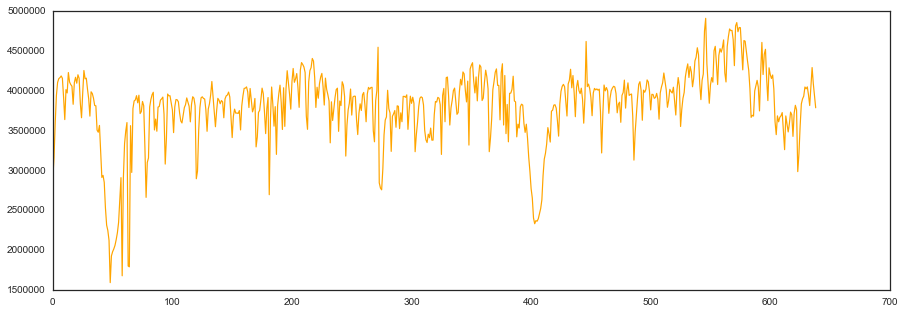

In [12]:
plt.figure(figsize=(15, 5))
train['power_consumption'].plot(c='orange', linewidth=1.2)

筛选出用电高峰期和低峰期...

In [13]:
train.describe()

,power_consumption
count,6.390000e+02
mean,3.805928e+06
std,4.749309e+05
min,1.589939e+06
25%,3.666518e+06
50%,3.894369e+06
75%,4.047454e+06
max,4.905574e+06


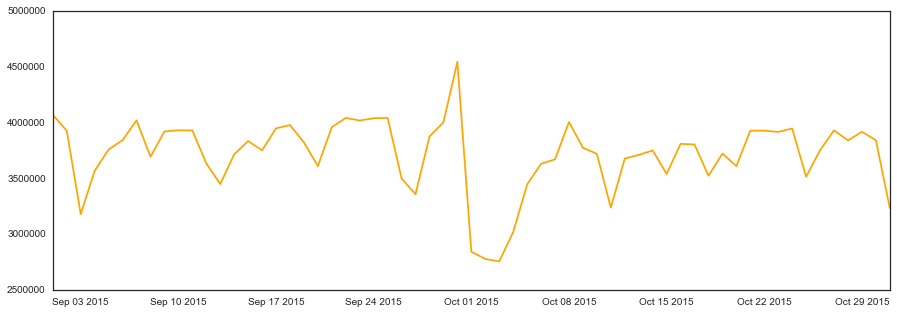

In [14]:
plt.figure(figsize=(15, 5))
NationalDay2015 = train[(train['record_date'] >= '2015-9-1')  & (train['record_date'] <= '2015-10-31')]
NationalDay2015.reset_index(drop=True, inplace=True)
plt.plot(NationalDay2015.record_date, NationalDay2015.power_consumption, c='orange')

In [15]:
train[(train.record_date >= '2015-10-1') & (train.record_date <= '2015-10-7')]

,record_date,power_consumption
273,2015-10-01,2841489.0
274,2015-10-02,2776441.0
275,2015-10-03,2754225.0
276,2015-10-04,3016280.0
277,2015-10-05,3443517.0
278,2015-10-06,3629157.0
279,2015-10-07,3669034.0


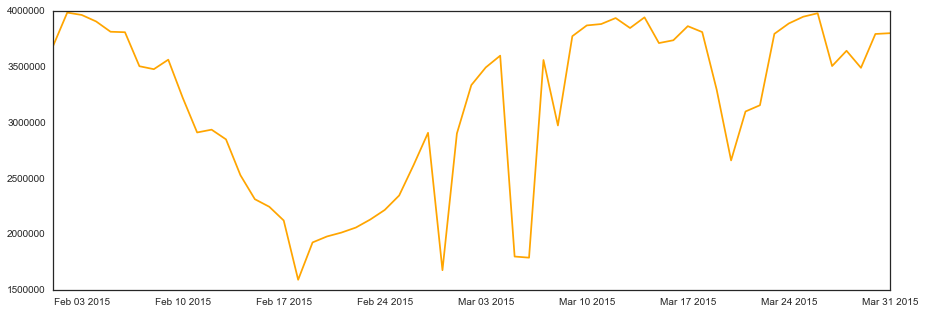

In [16]:
plt.figure(figsize=(15, 5))
SpringFestival2015 = train[(train['record_date'] >= '2015-2-1')  & (train['record_date'] <= '2015-3-31')]
SpringFestival2015.reset_index(drop=True, inplace=True)
plt.plot(SpringFestival2015.record_date, SpringFestival2015.power_consumption, c='orange')

In [17]:
train[(train.record_date >= '2015-02-18') & (train.record_date <= '2015-02-24')]

,record_date,power_consumption
48,2015-02-18,1589939.0
49,2015-02-19,1924576.0
50,2015-02-20,1978058.0
51,2015-02-21,2012807.0
52,2015-02-22,2057893.5
53,2015-02-23,2129969.0
54,2015-02-24,2215586.0


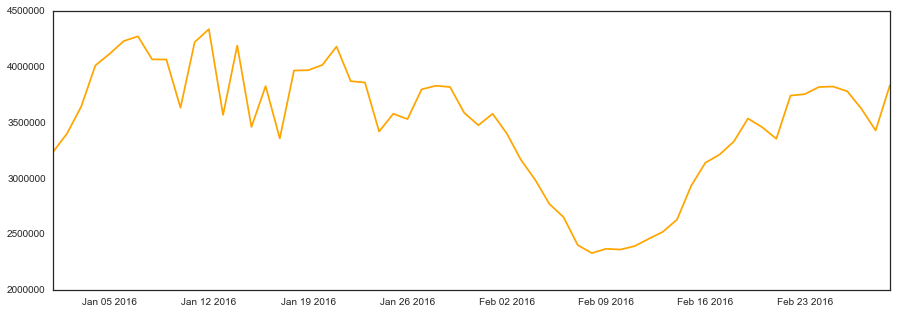

In [18]:
plt.figure(figsize=(15, 5))
SpringFestival2016 = train[(train['record_date'] >= '2016-1-1')  & (train['record_date'] <= '2016-2-29')]
SpringFestival2016.reset_index(drop=True, inplace=True)
plt.plot(SpringFestival2016.record_date, SpringFestival2016.power_consumption, c='orange')

In [19]:
train[(train.record_date >= '2016-02-07') & (train.record_date <= '2016-02-13')]

,record_date,power_consumption
402,2016-02-07,2400941.0
403,2016-02-08,2328935.0
404,2016-02-09,2367668.0
405,2016-02-10,2360456.0
406,2016-02-11,2390654.0
407,2016-02-12,2456605.0
408,2016-02-13,2519542.0


用电低峰正好是过年那会儿，大家都回家了，工厂、公司都歇业，也是理所当然的...

按照这种思想，其实我们可以从以下几种情况来考虑：

1. 节假日的用电情况按理来说低于平时的，如“十一长假”，“春节”，“清明节”，“劳动节”，“端午节”，“中秋”，“元旦”...
2. 周末的用电应该来说低于工作日
3. 一天当中，不同时间段的用电也会有细微差别，一般晚上用电大于白天用电...

因为这边的最小单位是按天，没有细分到小时，我们可以将日期细分到按年份，一年中的第几天，季度，月份，上中下旬，一个月的第几周，一个月的第几天，是否为周末，是否是节假日，十一长假和春节单独拎出来...

In [20]:
predict = pd.DataFrame({'record_date': pd.date_range('2016-10-01', '2016-10-31'),
                        'power_consumption': [0] * 31},
                      index=range(639, 670))
final = pd.concat([train, predict])

In [21]:
final.loc[:, 'year'] = final.record_date.dt.year
final.loc[:, 'month'] = final.record_date.dt.month
final.loc[:, 'week'] = final.record_date.dt.week
final.loc[:, 'day'] = final.record_date.dt.day
final.loc[:, 'dow'] = final.record_date.dt.dayofweek

In [22]:
# 不同季节，一般夏季、冬季明显多于春季、秋季
final.loc[final.month.isin([3, 4, 5]), 'season'] = 1
final.loc[final.month.isin([6, 7, 8]), 'season'] = 2
final.loc[final.month.isin([9, 10, 11]), 'season'] = 3
final.loc[final.month.isin([12, 1, 2]), 'season'] = 4

In [23]:
# 上中下旬
final.loc[final.day.isin(range(1, 11)), 'period_of_month'] = 1
final.loc[final.day.isin(range(11, 21)), 'period_of_month'] = 2
final.loc[final.day.isin(range(21, 32)), 'period_of_month'] = 3

In [24]:
# 上半月、下半月
final.loc[final.day.isin(range(1, 16)), 'period2_of_month'] = 1
final.loc[final.day.isin(range(16, 32)), 'period2_of_month'] = 2

In [25]:
# 一个月的第几周
final.loc[final.day.isin(range(1, 8)), 'period2_of_month'] = 1
final.loc[final.day.isin(range(8, 15)), 'period2_of_month'] = 2
final.loc[final.day.isin(range(15, 22)), 'period2_of_month'] = 3
final.loc[final.day.isin(range(22, 29)), 'period2_of_month'] = 4
final.loc[final.day.isin(range(29, 32)), 'period2_of_month'] = 5

In [26]:
# 周末
final.loc[final.dow.isin([0, 6]), 'weekend'] = 1

# 周六
final.loc[final.dow.isin([6]), 'weekend_sat'] = 1

# 周日
final.loc[final.dow.isin([0]), 'weekend_sun'] = 1

In [27]:
# 节假日
final.loc[final.record_date.isin(['2015-01-01', '2015-01-02', '2015-01-03', '2015-04-04', '2015-04-05', '2015-04-06',
'2015-05-01', '2015-05-02', '2015-05-03', '2015-06-20', '2015-06-21', '2015-06-22', '2015-09-26', '2015-09-27', '2016-01-01', 
'2016-01-02', '2016-01-03', '2016-04-02', '2016-04-03', '2016-04-04', '2016-04-30', '2016-05-01', '2016-05-02', '2016-06-09', 
'2015-06-10', '2015-06-11', '2016-09-15', '2016-09-16', '2016-09-17']), 'festival'] = 1

In [28]:
# 国庆节
final.loc[final.record_date.isin(['2015-10-01', '2015-10-02', '2015-10-03', '2015-10-04', '2015-10-05', '2015-10-06', '2015-10-07',
'2016-10-01', '2016-10-02', '2016-10-03', '2016-10-04', '2016-10-05', '2016-10-06', '2016-10-07']), 'nationalday'] = 1

# 国庆节前三天
final.loc[final.record_date.isin(['2015-10-01', '2015-10-02', '2015-10-03', 
                                  '2016-10-01', '2016-10-02', '2016-10-03']), 'firstthreedaysofnationalday'] = 1

# 国庆节后四天
final.loc[final.record_date.isin(['2015-10-04', '2015-10-05', '2015-10-06', '2015-10-07', 
                                  '2016-10-04', '2016-10-05', '2016-10-06', '2016-10-07']), 'lastfourdaysofnationalday'] = 1

In [29]:
# 春节
final.loc[final.record_date.isin(['2015-02-18', '2015-02-19', '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23', '2015-02-24', 
'2016-02-07', '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13']), 'springfestival'] = 1

In [30]:
final.fillna(0, inplace=True)
final.loc[:, final.columns[6:]] = final[final.columns[6:]].astype('int')

In [31]:
final.columns

Index(['power_consumption', 'record_date', 'year', 'month', 'week', 'day',
       'dow', 'season', 'period_of_month', 'period2_of_month', 'weekend',
       'weekend_sat', 'weekend_sun', 'festival', 'nationalday',
       'firstthreedaysofnationalday', 'lastfourdaysofnationalday',
       'springfestival'],
      dtype='object')

In [32]:
to_be_encoder = final.columns[2:]

In [33]:
dummies = pd.get_dummies(final, prefix=to_be_encoder, columns=to_be_encoder)

In [34]:
dummies.columns

Index(['power_consumption', 'record_date', 'year_2015', 'year_2016', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       ...
       'festival_0', 'festival_1', 'nationalday_0', 'nationalday_1',
       'firstthreedaysofnationalday_0', 'firstthreedaysofnationalday_1',
       'lastfourdaysofnationalday_0', 'lastfourdaysofnationalday_1',
       'springfestival_0', 'springfestival_1'],
      dtype='object', length=135)

In [35]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Columns: 135 entries, power_consumption to springfestival_1
dtypes: datetime64[ns](1), float64(1), uint8(133)
memory usage: 97.6 KB


#### 训练模型

In [36]:
from sklearn.linear_model import LinearRegression

trainDataLinear = dummies.loc[:638]
testDataLinear = dummies.loc[639:]

X_train_linear = trainDataLinear[trainDataLinear.columns[2:]]
y_train_linear = trainDataLinear[trainDataLinear.columns[0]]

X_test_linear = testDataLinear[testDataLinear.columns[2:]]

LinearR = LinearRegression()
LinearR.fit(X_train_linear, y_train_linear)

y_test_linear = LinearR.predict(X_test_linear)
y_test_linear

array([2531328., 2392064., 2990080., 3571712., 3448832., 3588096.,
       3670016., 3768320., 3596288., 3915776., 3997696., 4030464.,
       4096000., 3932160., 3801088., 3661824., 3858432., 4005888.,
       3997696., 3981312., 4022272., 3973120., 3801088., 3981312.,
       3989504., 4022272., 4120576., 3923968., 3858432., 3653632.,
       3735552.])

In [37]:
LinearR.score(X_train_linear, y_train_linear)

0.7015240354426536

#### 交叉验证

In [38]:
from sklearn.model_selection import cross_val_score, train_test_split

X_split_train, X_split_val, y_split_train, y_split_val= train_test_split(X_train_linear, y_train_linear, test_size=0.3, random_state=0)

Linear = LinearRegression()
Linear.fit(X_split_train, y_split_train)

Linear.score(X_split_val, y_split_val)

-3.0189634051096515e+24

In [39]:
cross_val_score(LinearR, X_train_linear, y_train_linear, cv=5).mean()

-4.251001095747625e+27

#### 构建树模型

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

trainDataTree = final.loc[:638]
testDataTree = final.loc[639:]

X_train_tree = trainDataTree[trainDataTree.columns[2:]]
y_train_tree = trainDataTree[trainDataTree.columns[0]]

X_test_tree = testDataTree[testDataTree.columns[2:]]

rfr = RandomForestRegressor(n_estimators=120, max_depth=25, min_samples_split=2, min_samples_leaf=1, n_jobs=-1, oob_score=True)
rfr.fit(X_train_tree, y_train_tree)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [41]:
# gscv = GridSearchCV(rfr, param_grid={
#    'max_depth': [5, 8, 15, 25],
#    'min_samples_split': [2, 5, 10, 20],
#    'min_samples_leaf': [1, 2, 5, 10],
#    'n_estimators': [10, 50, 120, 300]
# }, cv=5, n_jobs=-1)
# gscv.fit(X_train, y_train)

In [42]:
# gscv.best_score_

In [43]:
# gscv.best_params_

In [44]:
y_test_tree = rfr.predict(X_test_tree)

In [45]:
rfr.score(X_train_tree, y_train_tree)

0.9723634688800764

In [46]:
y_test_tree

array([3270798.39166667, 3211755.63333333, 3377625.43333333,
       3649317.68333333, 3672814.11666667, 3669830.875     ,
       3682951.73333333, 3760298.18333333, 3596857.80833333,
       3830748.24166667, 3838876.84166667, 3842122.225     ,
       3817588.95833333, 3814204.58333333, 3749265.56666667,
       3616936.74166667, 3823254.63333333, 3893768.91666667,
       3904615.86666667, 3918913.30833333, 3967552.66666667,
       3918986.07916667, 3743026.32916667, 3995728.48333333,
       3974477.93333333, 3978206.49166667, 4022300.26666667,
       3962635.35833333, 3826970.16666667, 3669522.32083333,
       3887016.57916667])

In [47]:
y_test_tree.mean()

3770611.884408603

In [48]:
cross_val_score(rfr, X_train_tree, y_train_tree, cv=5).mean()

0.23695101231585664

In [49]:
pd.DataFrame({'features': final.columns[2:], 'feature_importances': rfr.feature_importances_}, columns=['features', 'feature_importances'])

,features,feature_importances
0,year,0.082386
1,month,0.080558
2,week,0.245623
3,day,0.126339
4,dow,0.078656
5,season,0.036328
6,period_of_month,0.010752
7,period2_of_month,0.015124
8,weekend,0.007326
9,weekend_sat,0.017971


#### 构建SVR

SVR对于异常点和幅度都是敏感的，与LinearR一样需要标准化操作

In [50]:
from sklearn.ensemble import AdaBoostRegressor

adalinear = AdaBoostRegressor(LinearR, n_estimators=100)
adalinear.fit(X_train_linear, y_train_linear)

AdaBoostRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
         learning_rate=1.0, loss='linear', n_estimators=100,
         random_state=None)

In [51]:
y_test_adalinear = adalinear.predict(X_test_linear)

In [52]:
y_test_adalinear.mean()

3832784.5161290322

In [53]:
cross_val_score(adalinear, X_train_linear, y_train_linear, cv=5).mean()

-1.0255905706133206e+23

In [54]:
from sklearn.svm import SVR

svr = SVR(C=1000)
svr.fit(X_train_linear, y_train_linear)
svr.predict(X_test_linear)

gcv = GridSearchCV(estimator=svr, param_grid={
    'C': [0.001, 0.01, 0.1, 0.5, 1.0, 10.0, 100.0, 1000.0]
}, n_jobs=-1, cv=5)
gcv.fit(X_train_linear, y_train_linear)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [55]:
adasvr = AdaBoostRegressor(LinearR, n_estimators=100)
adasvr.fit(X_train_linear, y_train_linear)

AdaBoostRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
         learning_rate=1.0, loss='linear', n_estimators=100,
         random_state=None)

In [56]:
y_test_adasvr = adasvr.predict(X_test_linear)

In [57]:
y_test_adasvr.mean()

3797702.193548387

In [58]:
cross_val_score(adasvr, X_train_linear, y_train_linear, cv=5).mean()

-1.0099954558874938e+23

#### 填充结果

In [59]:
final.loc[639:, 'power_consumption'] = (y_test_tree + y_test_adalinear + y_test_adasvr) / 3

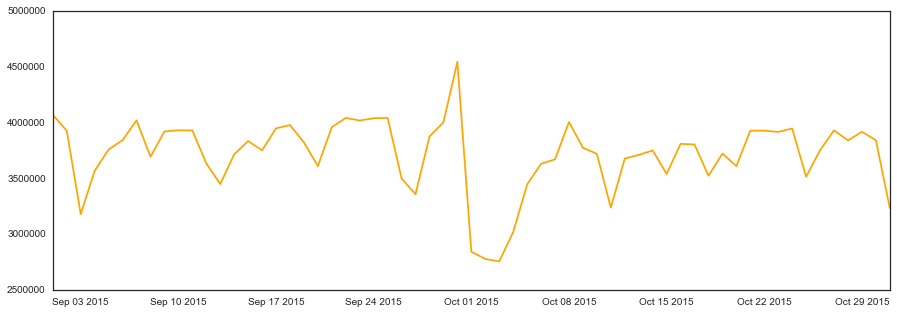

In [60]:
plt.figure(figsize=(15, 5))
NationalDay2015 = train[(train['record_date'] >= '2015-9-1')  & (train['record_date'] <= '2015-10-31')]
NationalDay2015.reset_index(drop=True, inplace=True)
plt.plot(NationalDay2015.record_date, NationalDay2015.power_consumption, c='orange')

In [61]:
final[(final.record_date >= '2015-10-1') & (final.record_date <= '2015-10-7')]

,power_consumption,record_date,year,month,week,day,dow,season,period_of_month,period2_of_month,weekend,weekend_sat,weekend_sun,festival,nationalday,firstthreedaysofnationalday,lastfourdaysofnationalday,springfestival
273,2841489.0,2015-10-01,2015,10,40,1,3,3,1,1,0,0,0,0,1,1,0,0
274,2776441.0,2015-10-02,2015,10,40,2,4,3,1,1,0,0,0,0,1,1,0,0
275,2754225.0,2015-10-03,2015,10,40,3,5,3,1,1,0,0,0,0,1,1,0,0
276,3016280.0,2015-10-04,2015,10,40,4,6,3,1,1,1,1,0,0,1,0,1,0
277,3443517.0,2015-10-05,2015,10,41,5,0,3,1,1,1,0,1,0,1,0,1,0
278,3629157.0,2015-10-06,2015,10,41,6,1,3,1,1,0,0,0,0,1,0,1,0
279,3669034.0,2015-10-07,2015,10,41,7,2,3,1,1,0,0,0,0,1,0,1,0


In [62]:
final[(final.record_date >= '2015-10-1') & (final.record_date <= '2015-10-31')]['power_consumption'].mean()

3604101.193548387

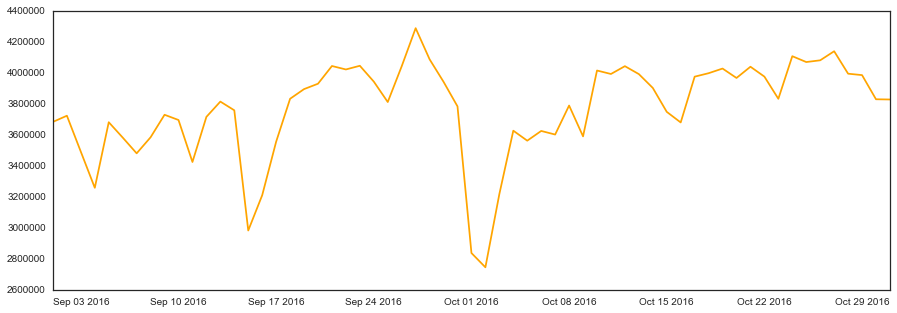

In [63]:
plt.figure(figsize=(15, 5))
NationalDay2016 = final[(final['record_date'] >= '2016-9-1')  & (final['record_date'] <= '2016-10-31')]
NationalDay2016.reset_index(drop=True, inplace=True)
plt.plot(NationalDay2016.record_date, NationalDay2016.power_consumption, c='orange')

In [64]:
final[(final.record_date >= '2016-10-1') & (final.record_date <= '2016-10-7')]

,power_consumption,record_date,year,month,week,day,dow,season,period_of_month,period2_of_month,weekend,weekend_sat,weekend_sun,festival,nationalday,firstthreedaysofnationalday,lastfourdaysofnationalday,springfestival
639,2.837210e+06,2016-10-01,2016,10,39,1,5,3,1,1,0,0,0,0,1,1,0,0
640,2.745167e+06,2016-10-02,2016,10,39,2,6,3,1,1,1,1,0,0,1,1,0,0
641,3.217566e+06,2016-10-03,2016,10,40,3,0,3,1,1,1,0,1,0,1,1,0,0
642,3.626594e+06,2016-10-04,2016,10,40,4,1,3,1,1,0,0,0,0,1,0,1,0
643,3.562063e+06,2016-10-05,2016,10,40,5,2,3,1,1,0,0,0,0,1,0,1,0
644,3.624898e+06,2016-10-06,2016,10,40,6,3,3,1,1,0,0,0,0,1,0,1,0
645,3.601624e+06,2016-10-07,2016,10,40,7,4,3,1,1,0,0,0,0,1,0,1,0


In [65]:
final[(final.record_date >= '2016-10-1') & (final.record_date <= '2016-10-31')]['power_consumption'].mean()

3800366.1980286743